# Using GANs - Generative Aversarial Networks
The base concept of a GAN in this scenario is that we have two seperate neural networks which are trained differently.

There is a Discriminator and a Generator network with different inputs and outputs.

The discriminator classifies images as real or not real (In other words, as coming from the generated distribution or the real data distribution). In this case, the input is an image, and the output is a probability of the input belonging to the real dataset distribution.

The generator takes in random seeds and will output an image.

Training the Generator
Both networks need to be implemented at the same time, but the weights must be updated at different times. To train the generator, we freeze the discriminator weights. We input just random seeds to the generator and the output images are fed into the discriminator. Which will try and evaluate whether they are generated or not. So the labels for this step are all $y_i=1.0$. Backpropagation trains the generator to produce images that better "fool" the discriminator


Training the Discriminator
We freeze the weights of the Generator, we generate images with the generator, and we take the same number of images from the input data distribution. These are fed into the discriminator which outputs probabilities of being from the input dataset. Thus backpropagation will train the discriminator to be able to distinguish real from generated images.

In [2]:
import tensorflow as tf
tf.enable_eager_execution()
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, LeakyReLU, Dropout, ZeroPadding2D, ReLU
from tensorflow.keras.layers import BatchNormalization, Flatten, Dense, UpSampling2D
from tensorflow.keras.layers import Reshape, Activation, Conv2DTranspose
from tensorflow.keras.layers import AveragePooling2D, Input, Add
from tensorflow.keras.backend import resize_images

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.Session(config=config)

import numpy as np
import csv
import time
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import dask.array as da


## Defining the Models
We have two models to define, the generator and the discriminator. 

Intuitively, if the output we want to generate are images, then the discriminator will be a ConvNet, since it needs to extract features from an image to output a single numerical prediction. So it's no surprise our model takes the image and applies a series of convolutions. To prevent overfitting, we also apply Dropout to our layers.

On the other hand, the generator takes in a vector seed and generates an image. So intuitively it must be composed of a series of upsamplings, which it is.

In [2]:
def get_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

def get_generator(seed_size):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D(size=(2,2)))
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    # Final CNN layer
    model.add(Conv2D(3,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

## Helper Functions
Here I'll define functions that help with training the GAN.

First, we need to define the loss function for both the discriminator and the generator since these are trained differently.

I'll also define a helper function to save progress images of the training

In [3]:
def loss_generator(Y_hat):
    """
    Implements Binary Crossentropy Loss for the Generator
    
    Arguments:
    Y_hat -- Discriminator Predictions
    
    Returns:
    loss -- BinaryCrossentropy loss for the generator
    """
    #Recall the generator is trained on y_hats of only one
    Y = tf.ones_like(Y_hat)
    loss = BinaryCrossentropy(from_logits=True)(Y, Y_hat)
    return loss

def loss_discriminator(Y_hat_real, Y_hat_gen):
    """
    Implements BinaryCrossentropy loss for the Discriminator
    
    Arguments:
    Y_hat_real -- Predictions on real distribution samples
    Y_hat_gen -- Predictions on generated samples
    
    Returns:
    total -- Combined Real and Generated loss of Discriminator
    """
    entropy  = BinaryCrossentropy(from_logits=True)
    Y_real = tf.ones_like(Y_hat_real)
    Y_gen = tf.zeros_like(Y_hat_gen)
    loss_real = entropy(Y_real, Y_hat_real)
    loss_gen =  entropy(Y_gen, Y_hat_gen)
    total = loss_real+loss_gen
    return total

def save_images(output_path, epoch, seed):
    image_array = np.full((16 + (4 * (W+16)), 16 + (7 * (H+16)), 3), 255, dtype=np.uint8)

    generated_images = generator.predict(seed)

    generated_images = 0.5 * generated_images + 0.5

    image_count = 0
    for row in range(4):
        for col in range(7):
            r = row * (W+16) + 16
            c = col * (H+16) + 16
            image_array[r:r+W,c:c+H] = generated_images[image_count] * 255
            image_count += 1

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    filename = os.path.join(output_path,"train-%s.png"%epoch)
    im = Image.fromarray(image_array)
    im.save(filename)

## Defining a Training step
Tensorflow allows for precise control over what a training step is comprised of.  `tf.function`  takes a python function and converts it to a graph representation that Tensorflow can use to perform automatic differentiation efficiently. Additionally, it provides us the power to control how the discriminator and generator get updated.

It is interesting how this process is accomplished. `tf.GradientTape()` allows Tensorflow to keep track of the operations defined in the function and then apply automatic differentiation.

I'll list through the operations that a training step requires:
<ol>
    <li>Generate a random seed to input to the Generator</li>
    <li>Obtain a generated dataset from the generator given the input seed</li>
    <li>Obtain predictions from the discriminator on the dataset obtained from the real distribution</li>
    <li>Obtian predictions from the discriminator on the generated dataset</li>
    <li>Obtain losses for both generator and discriminator</li>
    <li>Using Automatic Differentiation, obtain the gradients for the generator and discriminator </li>
    <li>Apply Backpropagation using the gradients.</li>
</ol>

In [4]:
@tf.function
def step(batch):
    X_real, Y_real = batch
    seed = tf.random.normal([X_real.shape[0], Y_real.shape[1]])
    
    #GradientTape - how tf does automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        X_gen = generator(seed, training=True)
        
        Y_hat_real = discriminator(X_real, training=True)
        Y_hat_gen = discriminator(X_gen, training=True)
        
        gen_loss = loss_generator(Y_hat_gen)
        disc_loss = loss_discriminator(Y_hat_real, Y_hat_gen)
        
        generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
        discriminator_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))
        
        return gen_loss, disc_loss
        

In [5]:
def train(dataset, epochs, seed_size):
    fixed_seed = np.random.normal(0, 1, (4 * 7, seed_size))
    start = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()

        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            t = step(image_batch)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])

        g_loss = sum(gen_loss_list) / len(gen_loss_list)
        d_loss = sum(disc_loss_list) / len(disc_loss_list)

        epoch_elapsed = time.time()-epoch_start
        print ('Epoch %i, gen loss=%f,disc loss=%f \t %f' % (epoch+1, g_loss, d_loss, epoch_elapsed))
        save_images(output_path,epoch,fixed_seed )

    elapsed = time.time()-start
    print ('Training time: %f' % elapsed)
    

## Preparing the Dataset
I'll be training the GAN on Google's [Cartoon Set](https://google.github.io/cartoonset/). The premise is to be able to generate good-enough looking faces with set categories to be able to play a randomized game of [Guess Who](https://en.wikipedia.org/wiki/Guess_Who%3F).

The dataset is comprised of 10,000 randomly generated cartoon faces, each with .csv files containing the descriptive features.

The size of these images are $500\times500$. This is too large for my current GPU setup, so I'll shrink it down to $64\times64$. Additionally, the .csv files hold set characteristics about the cartoon such as type of hair, eye color, etc. This allows us to create seeds to represent each of the cartoons.

In [3]:
dataset_path = './cartoonset10k/'

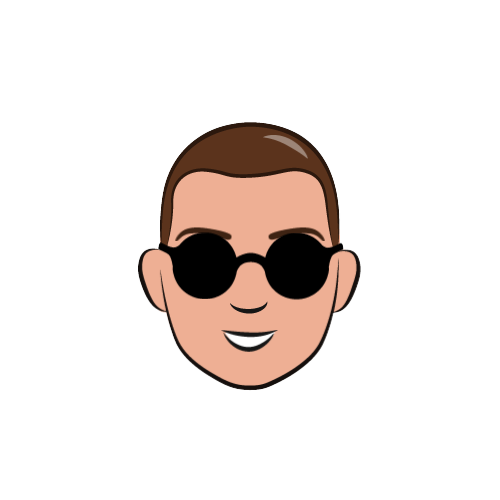

In [5]:
#Visualize one entry
files = os.listdir(dataset_path)

i = np.random.randint(len(files)//2)

#Investigate one sample
file_name = files[i].split('.')[0]
#Images are .png
image_path = os.path.join(dataset_path, file_name+'.png')
csv_path = os.path.join(dataset_path, file_name+'.csv')

Image.open(image_path)

In [6]:
#View csv file
characteristics = []
variants = []
total_variants = []
with open(csv_path) as f:
    reader = csv.reader(f)
    for row in reader:
        characteristic, value, num = row
        characteristics.append(characteristic)
        variants.append(float(value))
        total_variants.append(float(num))
unique_seed = np.asarray(variants)/(np.asarray(total_variants)/2)-1.0
print("Charateristics are:\n %s" % str(characteristics))
print("Unique Seed:\n %s" % str(unique_seed))

Charateristics are:
 ['eye_angle', 'eye_lashes', 'eye_lid', 'chin_length', 'eyebrow_weight', 'eyebrow_shape', 'eyebrow_thickness', 'face_shape', 'facial_hair', 'hair', 'eye_color', 'face_color', 'hair_color', 'glasses', 'glasses_color', 'eye_slant', 'eyebrow_width', 'eye_eyebrow_distance']
Unique Seed:
 [-0.33333333  0.          0.         -0.33333333  0.         -0.57142857
 -0.5         0.42857143  0.86666667 -0.63963964  0.6         0.09090909
  0.2         0.5        -1.         -0.33333333  0.33333333 -1.        ]


Given the set number of characteristics, we can define unique seeds for each of the faces in our dataset. In doing so we can hope to create a structured latent space that allows us to tweak and generate images based on characteristics that we wish.

One aspect of note. Since the input images are PNG files they have 4 channels, RGBA, where the last one is the transparancy layer. This is useless to us, however it is not sufficient to just remove it as I found it produced artifacts near the borders of the face itself. Instead, we composite the image with a background, and can then safely remove the transparancy layer

In [1]:
def get_unique_seed(csv_path):
    """
    Function to determine seed for a given sample in the dataset
    
    Attributes:
    csv_path -- python string, path to the csv file
    
    Returns:
    unique_seed -- numpy array, unique seed of image, length equal to number of features in the dataset
    """
    variants = []
    total_variants = []
    with open(csv_path) as f:
        reader = csv.reader(f)
        for row in reader:
            _ , value, num = row
            variants.append(float(value))
            total_variants.append(float(num))
    unique_seed = np.asarray(variants)/(np.asarray(total_variants)/2)-1.0
    return unique_seed

def get_features(csv_path):
    """
    Obtains list of feature for the dataset
    
    Attributes:
    csv_path -- python string, path to the csv file
    
    Returns:
    features -- python list, features of a sample in the dataset. Fixed for the datset
    """
    features = []
    with open(csv_path) as f:
        reader = csv.reader(f)
        for row in reader:
            feat ,_,_ = row
            features.append(feat)
    return features
    

In [8]:
#Set width and height
W = 64
H = 64

X = []
Y = []

X_path = './X.npy'
Y_path = './Y.npy'

for i,file_name in tqdm(enumerate(os.listdir(dataset_path)), desc='Reading Data'):
    #Ensure only look at the images, to avoid duplicates
    if '.png' in file_name:
        name = file_name.split('.')[0]
        #Images are .png
        image_path = os.path.join(dataset_path, name+'.png')
        csv_path = os.path.join(dataset_path, name+'.csv')

        #Get feautures
        if i == 0:
            features = get_features(csv_path)

        #Get unique seed
        seed = get_unique_seed(csv_path)

        #Read and resize image
        png = Image.open(image_path).resize((W,H),Image.ANTIALIAS)
        background = Image.new('RGBA', png.size, (0,0,0))
        
        #Create alpha composite to avoid artifacts
        alpha_composite = Image.alpha_composite(background, png)
        
        img = np.asarray(alpha_composite)/127.5 - 1.0
        
        #Remove transparancy layer
        X.append(img[...,:3])
        Y.append(seed)

#Convert to np
X = np.asarray(X)
Y = np.asarray(Y)

X = np.reshape(X,(-1,W, H, 3))
X = X.astype(np.float32)

#Save
np.save(X_path,X)
np.save(Y_path, Y)

print('Done')

NameError: name 'dataset_path' is not defined

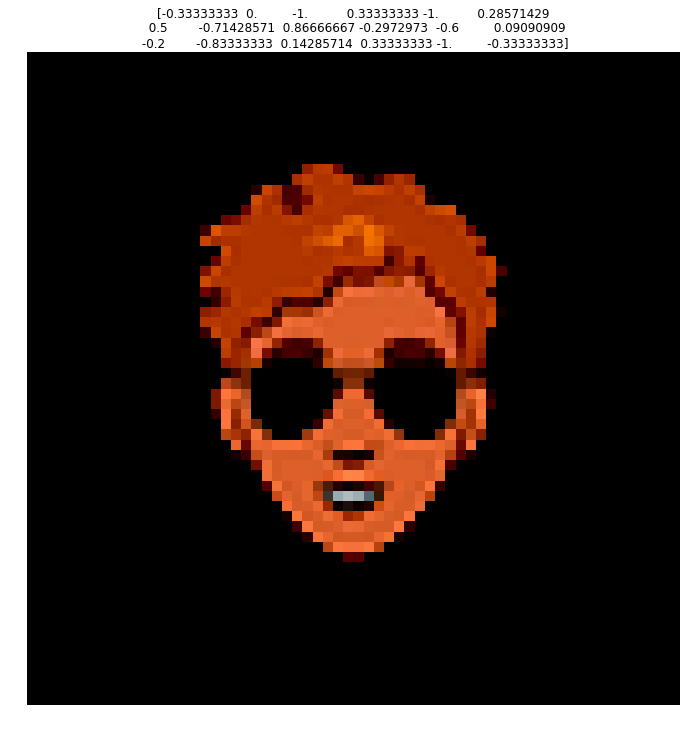

In [13]:
#Visualize one entry of the dataset
i = np.random.randint(X.shape[0])

fig, ax = plt.subplots()
fig.set_size_inches(12,12)
fig.set_facecolor('w')

ax.imshow(X[i])
ax.set_title(Y[i])
plt.axis('off')
plt.show()

## GAN Stability and Failure Modes

Before we start training, it is noteworthy to mention just how difficult GANs are to train. This difficulty arises because we need to train both a generative and discriminative model at the same time where improvements in one model will impact the other.

Because of this dynamic system, GANs can outright fail to converge. As such, I found it necessary to learn more about GAN stability and failure modes.

First, I'll analyze what a Stable GAN should look like while training. Some best practices are:
 - Use Leaky ReLU activations instead of ReLU, since it is often preferred to normalize inputs to be between $[-1,1]$, and ReLU will set any inputs less than $0$ to be $0$.
 - Use a Kernel Size that is a factor of the stride
 - Use hyperbolic tan (tanh) as the output layer activation
 
Once training begins, a stable GAN will have a generator loss somewhere around $[1.0,2.0]$ or higher, whereas the discriminator should hover around $0.5-0.8$.

Accuracy of the discriminator on both generated and real images should be around $0.7,0.8$

Personally, while training, I found that the initial training steps are crucial for stable training. I attempted several values of the learning rate parameter $\alpha$ which kept halting training without converging. The issue with this is that I required a very small $\alpha$ ($5.0\cdot 10^{-6}$) to be able to overcome the initial "turbulence", however after becoming stable the improvements made were very slow as a result. 


## Training the Model

In [7]:
X_path = './X.npy'
Y_path = './Y.npy'

#Load the data
X = np.load(X_path)
Y = np.load(Y_path)

#Shuffle data
idx = np.random.permutation(range(X.shape[0]))
X = X[idx]
Y = Y[idx]

#Dataset parameters
batch_size = 8

#Convert to unshuffled tensorflow dataset object
dataset = tf.data.Dataset.from_tensor_slices((X,Y)).batch(batch_size)

Both the Generator and Discriminator will be optimized with Adam. Adam has three parameters that define it. It can be thought of combining Gradient Descent with RMSProp and Momentum. So it inherits the learning rate $\alpha$ parameter, as well as $\beta_1$ from momentum and $\beta_2$ from RMSProp. For a more in depth look at different optimizers, you can reference my implementation of neural nets from scratch in NumPy here.

In [8]:
#
W = 64
H = 64
output_path = './figures'

#Define seed size
seed_size = Y.shape[1]

#Get models
generator = get_generator(seed_size)
discriminator = get_discriminator(X.shape[1:])

#Alpha and Beta1 may need tuning. Beta2 most likely does not
alpha = 5.0e-6
beta_1 = 0.8
beta_2 = 0.999

#Get optimizers
generator_optimizer = Adam(learning_rate=alpha, beta_1=beta_1, beta_2=beta_2)
discriminator_optimizer = Adam(learning_rate=alpha, beta_1=beta_1, beta_2=beta_2)

#Define parameters
epochs = 500

In [ ]:
train(dataset, epochs, seed_size)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1, gen loss=0.679988,disc loss=1.362854 	 76.512750
Epoch 2, gen loss=0.693136,disc loss=1.386321 	 72.690860
Epoch 3, gen loss=0.693149,disc loss=1.386317 	 75.233255


At this point, I realized my hardware was poorly equiped to handle the training, especially since I had to set the learning rate so small. So I copied my code to [Google Colab](https://colab.research.google.com/) and used their GPU power to run the model for $500$ epochs. The Generator and Discriminator Losses are plotted below (I absentmindedly forgot to include a plot for $i=499$ and I didnt want to run the training for another 3 hours, so bear with me):
![alt text](./figures/loss_100_plot.png "Losses after 100 Epochs")


![alt text](./figures/loss_200_plot.png "Losses after 100 Epochs")

![alt text](./figures/loss_300_plot.png "Losses after 100 Epochs")

![alt text](./figures/loss_400_plot.png "Losses after 100 Epochs")



Additionally, for each epoch I saved a set of images from the same seed to see how training progressed over time, which is quite fascinating:


![alt text](./figures/training_0_500.gif)

## Exploring the Latent Space
Initially, I had hoped that by feeding the generator feature vectors corresponding to the features outlined in the .csv files for each picture, the model would learn a very structured latent space that would be easy to navigate. However, I found the model to have a very large bias when I did this, so I had to opt for random seeds instead to obtain the results shown above.

As such, We need to explore this latent space to verify if there are ways of tweaking the output. If there are (hopefully orthogonalized) methods of accomplishing this, It will allow us to control the outputs we get, and be able to generate faces for our game of Guess Who.

The seeds fed into the generator during training matched the number of features described in each .csv file, so they have dimension $1\times18$, taking values in the range $(-1,1)$

In [2]:
#Path to latest model (generator model that is)
model_path = './models/generator_500.h5'

#Load generator
generator = load_model(model_path, compile=False)

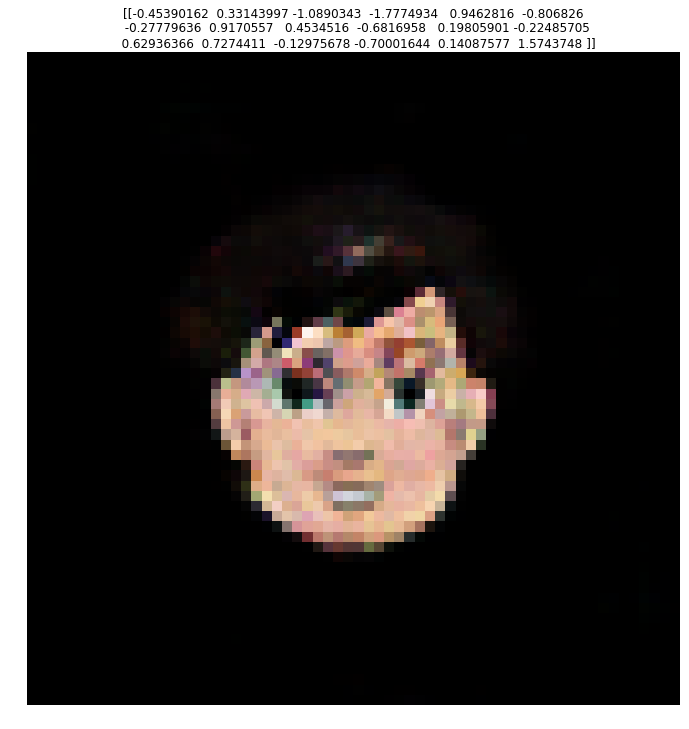

In [3]:
#Inference on random 1x18 vector
X_i = tf.random.normal([1,18])

#Get image, in range (-1,1)
y_hat = generator.predict(X_i)[0]

#Process image to be (0,255)
y = ((y_hat+1.0)*127.5).astype(np.int32)

fig,ax = plt.subplots()
fig.set_size_inches(12,12)
fig.set_facecolor('w')

ax.imshow(y)
ax.set_title(X_i.numpy())

plt.axis('off')
plt.show()

The image above is an example of inference done on the model. It actually looks quite a bit better than the images in the time-lapse above because its been rescaled to be in the range $(0,255)$ as intended.

My initial strategy to explore the latent space will be to have a baseline prediction of just zeros, and vary one feature at a time. I am not expecting the latent space to be orthogonalized like that, but it might give some indication of the changes that occur.

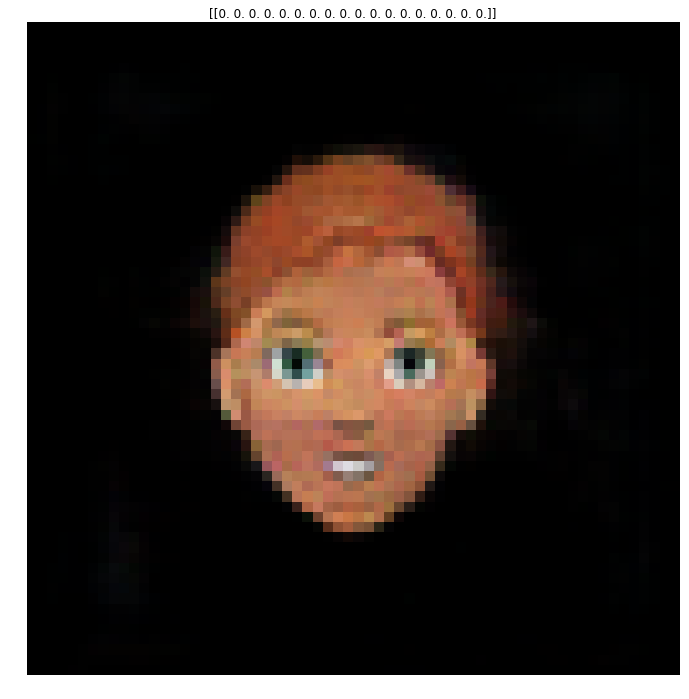

In [4]:
#Inference on zeros 1x18 vector
X_i = tf.zeros([1,18])

#Get image, in range (-1,1)
y_hat = generator.predict(X_i)[0]

#Process image to be (0,255)
y = ((y_hat+1.0)*127.5).astype(np.int32)

fig,ax = plt.subplots()
fig.set_size_inches(12,12)
fig.set_facecolor('w')

ax.imshow(y)
ax.set_title(X_i.numpy())

plt.axis('off')
plt.show()

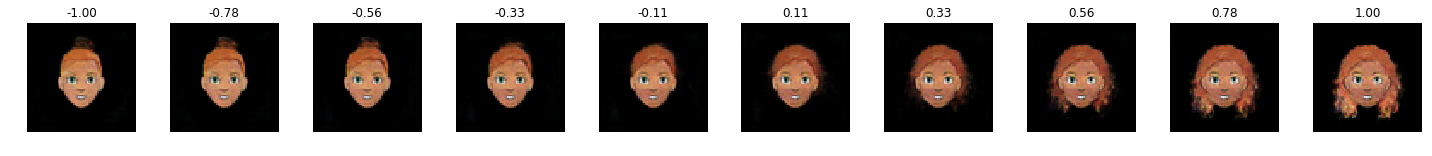

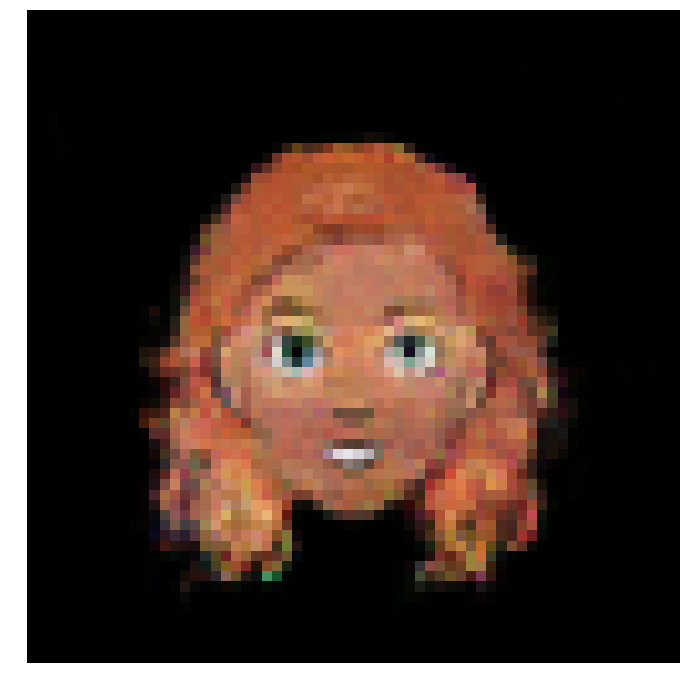

In [8]:
#Start with the inital row
num_samples = 10
X = np.zeros([num_samples, 18])
samples = np.linspace(-1,1,num=num_samples)
X[:,0]  = samples

Y = generator.predict(X)

fig, ax = plt.subplots(1,num_samples)
fig.set_size_inches(num_samples*2,12)
fig.set_facecolor('w')
for i in range(num_samples):
    y_hat = Y[i]
    y = ((y_hat+1.0)*127.5).astype(np.int32)
    ax[i].imshow(y)
    ax[i].set_title("%.02f" % samples[i])
    ax[i].axis('off')
fig.tight_layout()
plt.show()

#Make a finer sampling for gif
num_samples = 100
X = np.zeros([num_samples, 18])
samples = np.linspace(-1,1,num=num_samples)
X[:,0]  = samples

Y = generator.predict(X)

fig, ax = plt.subplots()
fig.set_size_inches(12,12)
fig.set_facecolor('w')
for i in range(num_samples):
    y_hat = Y[i]
    y = ((y_hat+1.0)*127.5).astype(np.int32)
    ax.imshow(y)
    ax.axis('off')
    plt.savefig('./figures/feature_1/frame_%i' % i)

This is absolutely incredible! The latent space seems smooth. We can see, however, it is not orthogonalized, since by changing this parameter we change not only the hair style, but color and skin color as well.

![alt text](./figures/feature_1.gif)


The next step is to do the same for every feature.

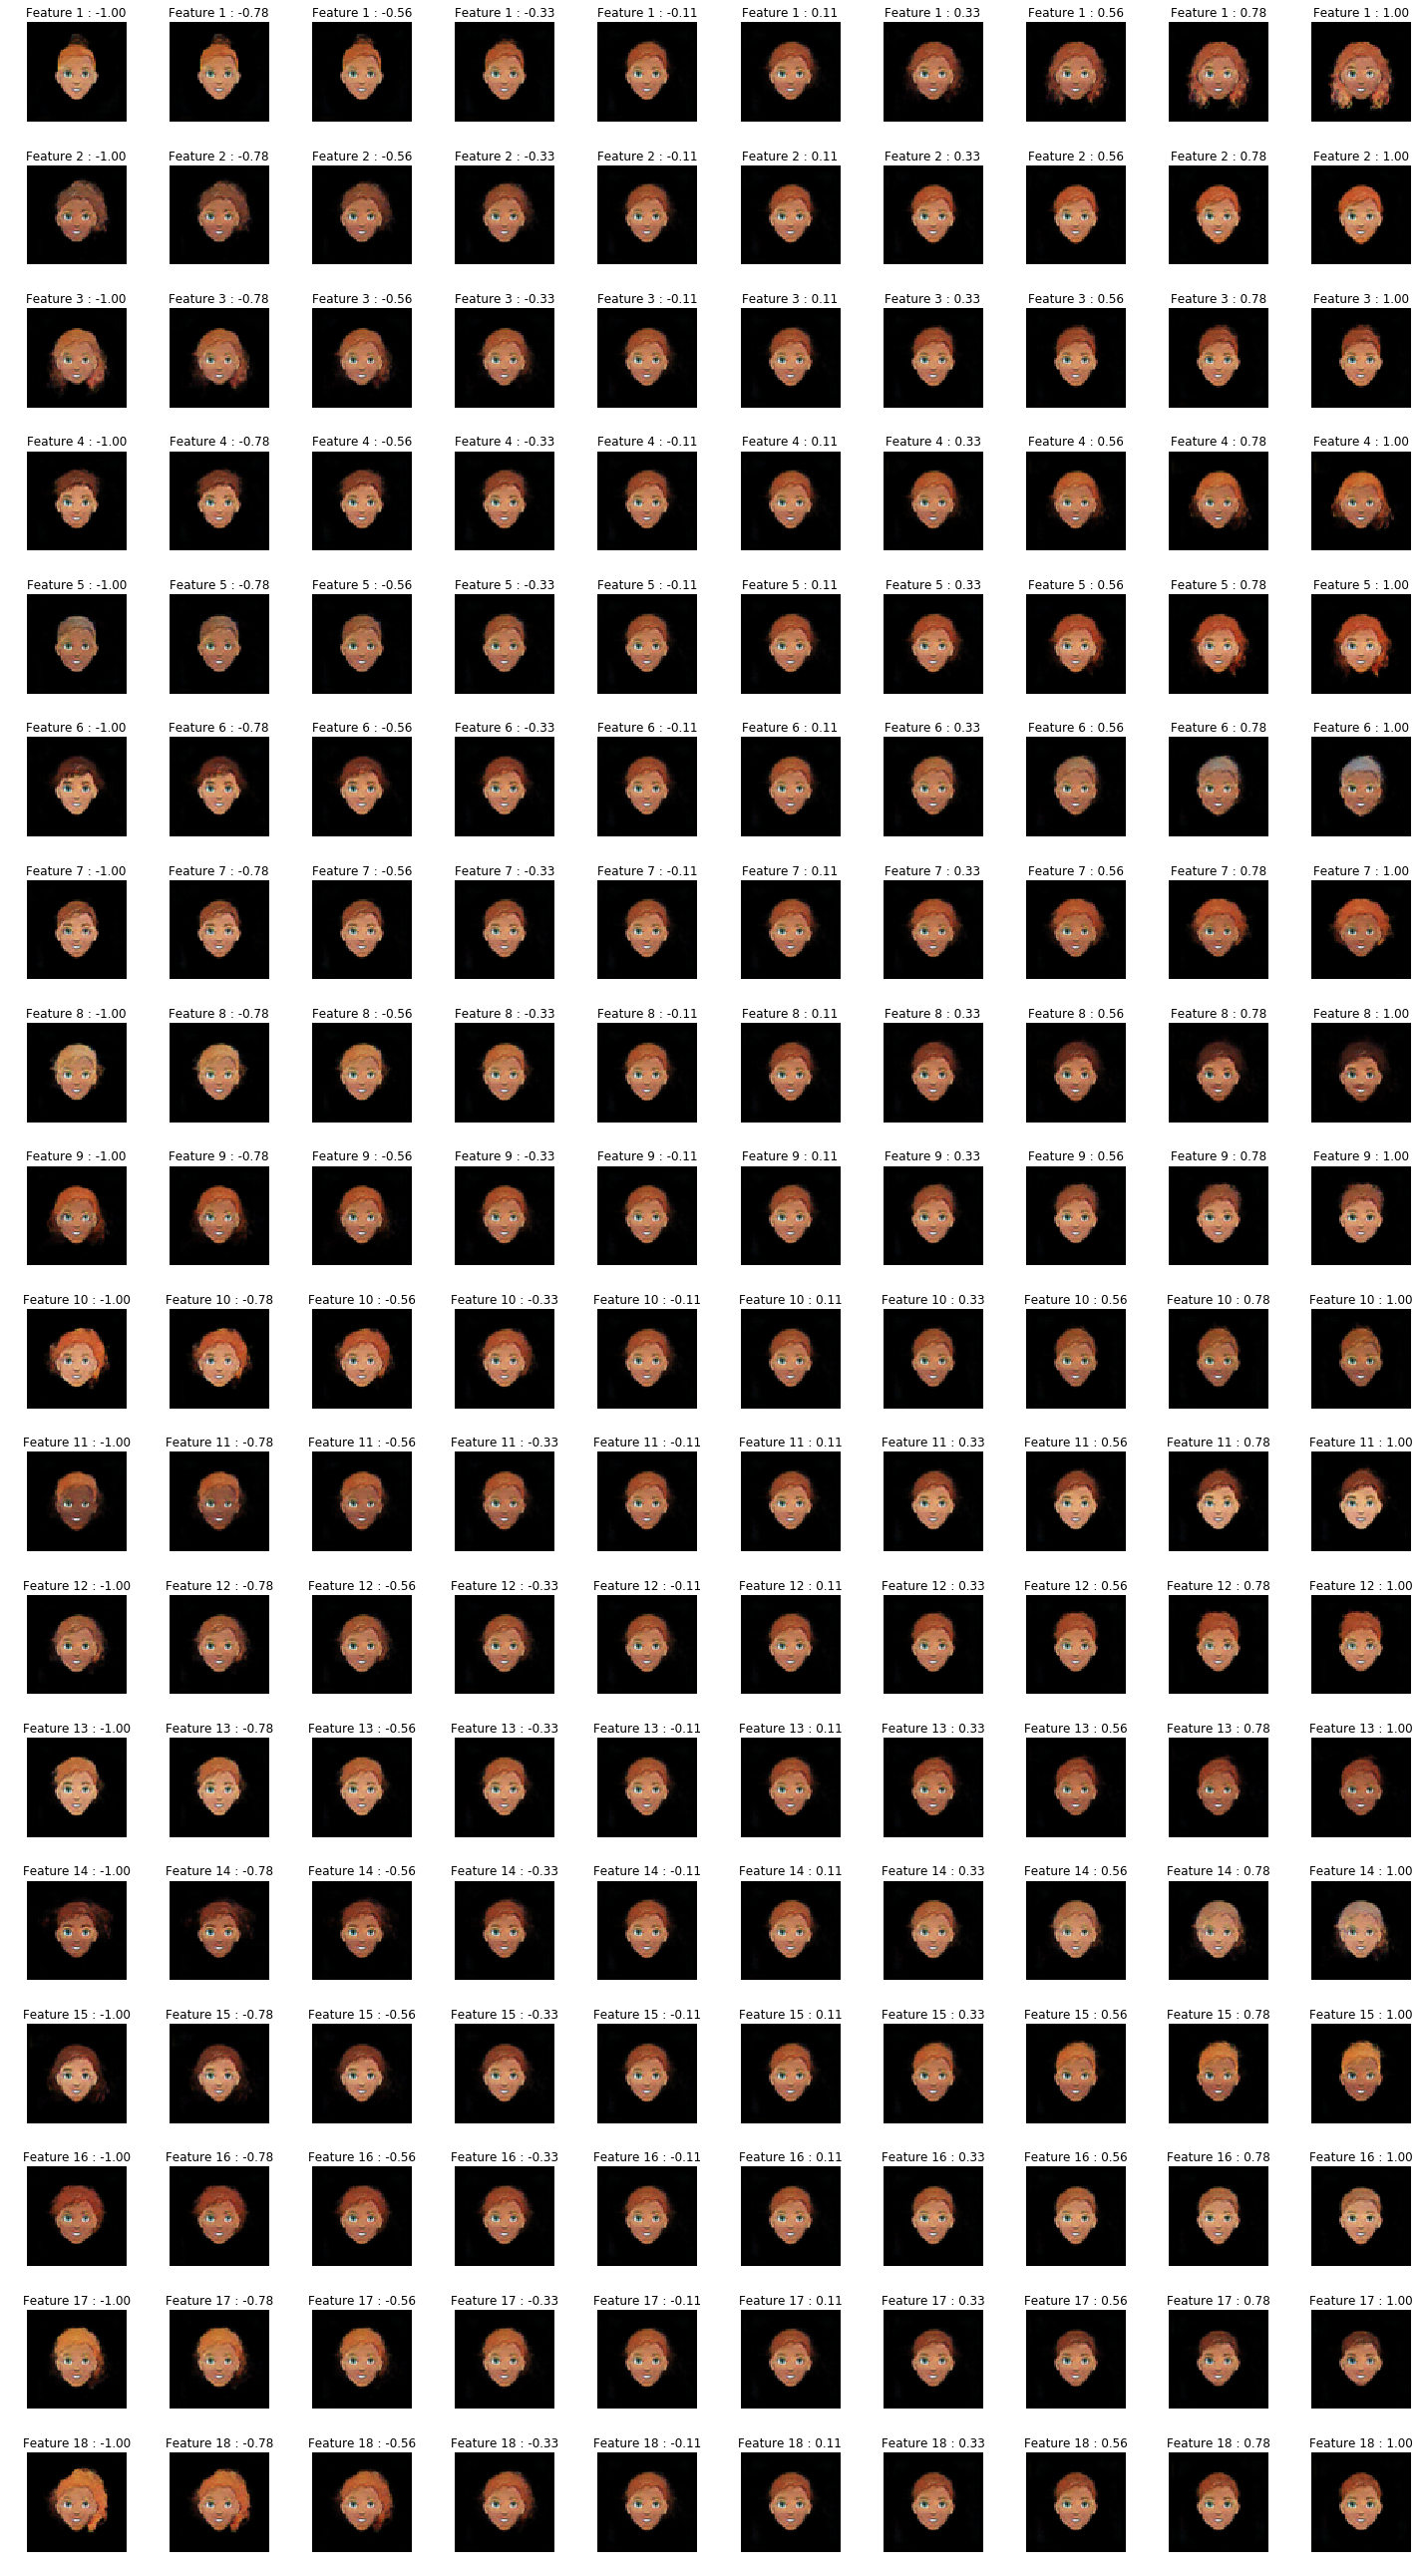

In [89]:
num_samples = 10
num_feats = 18
X = np.zeros([num_samples, num_feats])
samples = np.linspace(-1,1,num=num_samples)

fig, ax = plt.subplots(num_feats,num_samples)
fig.set_size_inches(num_samples*2,num_feats*2)
fig.set_facecolor('w')

for i in range(num_feats):
    X_i = np.copy(X)
    X_i[:,i] = samples

    Y = generator.predict(X_i)

    for j in range(num_samples):
        y_hat = Y[j]
        y = ((y_hat+1.0)*127.5).astype(np.int32)
        ax[i,j].imshow(y)
        ax[i,j].set_title("Feature %i : %.02f" % (i+1,samples[j]))
        ax[i,j].axis('off')
fig.tight_layout()
plt.savefig('./figures/latentspace.png',dpi=200)
plt.show()

In [7]:
variants

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 3.0,
 1.0,
 5.0,
 14.0,
 20.0,
 4.0,
 6.0,
 6.0,
 9.0,
 0.0,
 1.0,
 2.0,
 0.0]

## Super Resolution / Upsampling
Given the very large dataset of detailed images, we had to downscale the images to $64\times64$ to be able to fit in memory during training.

Now, I will train a super resolution model to upsample the images and obtain more detailed faces. I will be using the original dataset, in hopes that the GAN has learned a reasonable approximation to that distribution.

Now, the original $500x500$ scale may be too large for adequate mapping. I'll try with $256\times256$.

I'll use a model architecture called VDSR, which stands for Very Deep Super Resolution. You can check the paper out [here](https://arxiv.org/pdf/1511.04587.pdf)

In [3]:
dataset_path = './cartoonset10k/'

#Set input width and height
W_in = 64
H_in = 64

#Set output width and height
W_out = 256
H_out = 256

X = []
Y = []

X_path = './super_res_X.npy'
Y_path = './super_res_Y.npy'

files = os.listdir(dataset_path)
idx = np.random.randint(len(files), size=int(0.15*len(files)))

for i,file_name in tqdm(enumerate(np.asarray(files)[idx]), desc='Reading Data'):
    #Ensure only look at the images, to avoid duplicates
    if '.png' in file_name:
        name = file_name.split('.')[0]
        #Images are .png
        image_path = os.path.join(dataset_path, name+'.png')
        
        #Read and resize image
        png_in = Image.open(image_path).resize((W_in,H_in),Image.ANTIALIAS)
        background_in = Image.new('RGBA', png_in.size, (0,0,0))
        #Create alpha composite to avoid artifacts
        alpha_composite = Image.alpha_composite(background_in, png_in)
        img_in = np.asarray(alpha_composite)/127.5 - 1.0
        
        #Get label
        png_out = Image.open(image_path).resize((W_out, H_out), Image.BICUBIC)
        background_out = Image.new('RGBA', png_out.size, (0,0,0))
        #Create alpha composite to avoid artifacts
        alpha_composite = Image.alpha_composite(background_out, png_out)
        img_out = np.asarray(alpha_composite)/127.5-1.0
        
        X.append(img_in)
        Y.append(img_out)

#Convert to np
X = np.asarray(X)
Y = np.asarray(Y)

X = np.reshape(X[...,:3],(-1,W_in, H_in, 3))
X = X.astype(np.float32)

Y = np.reshape(Y[...,:3],(-1,W_out, H_out, 3))
Y = Y.astype(np.float32)

#Save
#np.save(X_path,X)
#np.save(Y_path, Y)

print('Done')

Reading Data: 3000it [00:21, 138.79it/s]


Done


In [4]:
def super_res_model(input_shape, output_shape):
    
    X_in = Input(shape = input_shape)
    X = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(X_in)
    X = Activation('relu')(X)
    for _ in range(18):
        X = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(X)
        X = Activation('relu')(X)
    
    #Final layer for residual image
    X = Conv2D(1, (3, 3), padding='same', kernel_initializer='he_normal')(X)
    
    X = Add()([X, X_in])
    model = Model(inputs = X_in, outputs = X)
    return model

In [5]:
#Set input width and height
W_in = 64
H_in = 64

#Set output width and height
W_out = 256
H_out = 256

#Resize input images with bicubic interpolation
h_factor = H_out/H_in
w_factor = W_out/ W_in
X_resized = resize_images(X, h_factor, w_factor,data_format='channels_last',interpolation='bilinear')

# model = super_res_model(X.shape[1:], Y.shape[1:])
# model.compile(optimizer='adam',loss='mean_absolute_error', metrics=['accuracy'])
# model.summary()

In [6]:
lr = 0.000007
epochs = 75

model = super_res_model(X_resized.shape.as_list()[1:], Y.shape[1:])
model.compile(optimizer=Adam(lr=lr),loss='mean_absolute_error', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       activation[0][0]                 
______________________________________________________________________________________________

In [ ]:
history = model.fit(X_resized.numpy(),Y,batch_size=1,epochs=60,validation_split=0.10)

In [ ]:
model_name = 'super_res_%f_%i' % (lr, epochs)
model.save('/content/gdrive/My Drive/Colab Notebooks/GAN/' + model_name + '.h5')

fig, ax = plt.subplots()
fig.set_size_inches(12,12)
fig.set_facecolor('w')

ax.plot(history.history['accuracy'], label = 'accuracy')
ax.plot(history.history['val_accuracy'], label = 'validation_accuracy')

ax2 = ax.twinx()

ax2.plot(history.history['loss'], label = 'mse_loss')
ax2.plot(history.history['val_loss'], label = 'validation_mse_loss')

plt.legend()
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/GAN/' + model_name+'_history.png')
plt.show()

![alt text](./figures/super_res_0.000007_75_history.png)

Unfortunately, my poor computer wasn't able to load the large tensors into RAM, even only using 20% of the dataset. So I trained the model in Google collab once more.

Here is a sample input from that model

![alt text](./figures/super_res_0.000007_75_example.png)

## Estabishing the Pipeline
So we have two trained models. The first one is the generator that takes in a vector of noise and outputs an image of dimension $64\times 64\times 3$.

We also have a trained VDSR model that takes in images of dimension $256\times 256\times 3$ and outputs images of dimension $256\times 256\times 3$.

The inputs to the VDSR model are bicubic resizes of the $64\times 64\times 3$ outputs.

In [20]:
#Path to latest generator model
gen_model_path = './models/generator_500.h5'

#Path to super resolution model
res_model_path = './models/super_res_0.000007_75.h5'

#Load generator
generator = load_model(gen_model_path, compile=False)
#Load super resolution model
super_res_model = load_model(res_model_path, compile=False)

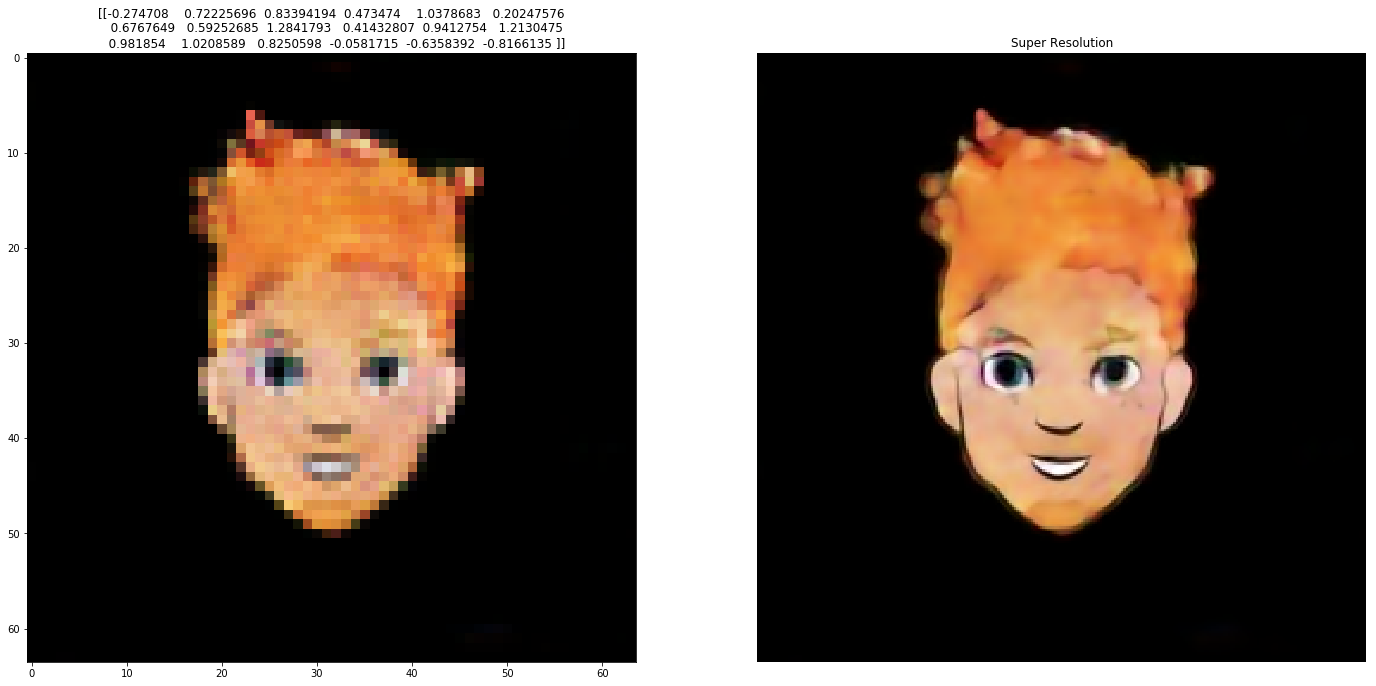

In [60]:
## Params
#Set input width and height
W_in = 64
H_in = 64

#Set output width and height
W_out = 256
H_out = 256

#Resize factor
h_factor = H_out/H_in
w_factor = W_out/ W_in

## Generator
#Inference on random 1x18 vector
X_i = tf.random.normal([1,18])
#Get image, in range (-1,1)
y_hat = generator.predict(X_i)[0]

#Process image to be (0,255)
y = ((y_hat+1.0)*127.5).astype(np.int32)

## Super Resolution
#Resize
y_resized = resize_images(np.expand_dims(y_hat, axis=0), h_factor, w_factor,data_format='channels_last',interpolation='bilinear')

#Get super resolution prediction
super_res_hat = super_res_model.predict(y_resized)[0]

#Process image to be (0,255)
super_res = ((super_res_hat+1.0)*127.5).astype(np.int32)

## Plotting
fig,ax = plt.subplots(1,2)
fig.set_size_inches(24,12)
fig.set_facecolor('w')

ax[0].imshow(y)
ax[0].set_title(X_i.numpy())

ax[1].imshow(super_res)
ax[1].set_title('Super Resolution')

plt.axis('off')
plt.show()